In [1]:
from jax import random as jran
import numpy as np
from matplotlib import pyplot as plt

ran_key = jran.key(0)

## Populate 500 halos at z=0.5 with synthetic galaxies

In [2]:
from rgrspit_diffsky import mc_galpop
from dsps.cosmology import DEFAULT_COSMOLOGY

lgmp_min = 11.0
n_halos = 500
logmhost = np.linspace(lgmp_min, 15, n_halos)
halo_radius = np.ones_like(logmhost)
z_obs = 0.02
mc_key, pos_key, vel_key = jran.split(ran_key, 3)
halo_pos = jran.uniform(pos_key, shape=(n_halos, 3))
halo_vel = jran.uniform(vel_key, shape=(n_halos, 3))
Lbox = 2_000.0

galcat = mc_galpop.mc_galpop_synthetic_subs(
    mc_key,
    logmhost,
    halo_radius,
    halo_pos,
    halo_vel,
    z_obs,
    lgmp_min,
    DEFAULT_COSMOLOGY,
    Lbox,
)
print(galcat.keys())

dict_keys(['mah_params', 'sfh_params', 'host_mah_params', 'upid', 'pos', 'vel', 'logmp0', 'logmp_t_obs', 'logmu_t_inf', 'logsm_t_obs', 'logssfr_t_obs', 't_table', 'log_mah_table', 'sfh_table', 't0', 'z_obs', 't_obs'])


In [3]:
hostid = np.where(galcat['upid']==-1, np.arange(len(galcat['upid'])).astype(int), galcat['upid'])
galcat['indx_host'] = np.copy(hostid)
galcat['logmp_host_t_obs'] = galcat['logmp_t_obs'][galcat['indx_host']]

In [4]:
from diffdesi.merging import merging_model as mmod
args = (mmod.DEFAULT_MERGE_PARAMS,
        galcat['logmp_t_obs'], 
        galcat['logmp_host_t_obs'], 
        galcat['t_obs'], galcat['mah_params'].t_peak, galcat['upid'])
p_merge = mmod.get_p_merge_from_merging_params(*args)

In [5]:
galcat['sfh_table_merging'] = mmod.merge(
    mmod.DEFAULT_MERGE_U_PARAMS,
    galcat['logmp_t_obs'], 
    galcat['logmp_host_t_obs'],
    galcat['t_obs'],
    galcat['mah_params'].t_peak,
    galcat['upid'],
    galcat['sfh_table'],
    galcat['indx_host'],
    1,
    1,
)
from diffstar.defaults import SFR_MIN
galcat['sfh_table_merging'] = np.where(galcat['sfh_table_merging']<SFR_MIN, SFR_MIN, galcat['sfh_table_merging'])

/Users/aphearin/miniforge3/envs/diffdev3129/lib/python3.12/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [6]:
from diffstar.utils import cumulative_mstar_formed_galpop
galcat['smh_table_merging'] = cumulative_mstar_formed_galpop(galcat['t_table'], galcat['sfh_table_merging'])

In [7]:
from jax import vmap
interp_vmap = jjit(vmap(jnp.interp, in_axes=(None, None, 0)))

In [8]:
galcat['logsm_t_obs_merging'] = interp_vmap(galcat['t_obs'], galcat['t_table'], np.log10(galcat['smh_table_merging']))

In [9]:
assert False

AssertionError: 

### Plot some MAHs for halos of different mass

In [ ]:
mskm115 = np.abs(galcat['logmp_t_obs'] - 11.5) < 0.2
mskm125 = np.abs(galcat['logmp_t_obs'] - 12.5) < 0.2
mskm135 = np.abs(galcat['logmp_t_obs'] - 13.5) < 0.2
mskm145 = np.abs(galcat['logmp_t_obs'] - 14.5) < 0.2

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(1.5, galcat['t_obs'])
ylim = ax.set_ylim(5e9, 5e14)
yscale = ax.set_yscale('log')

mred = u'#d62728' 
morange = u'#ff7f0e'  
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 
mpurple = u'#9467bd' 
for i in range(10):
    __=ax.plot(galcat['t_table'], 10**galcat['log_mah_table'][mskm115][i], lw=0.5, color=mblue)
    __=ax.plot(galcat['t_table'], 10**galcat['log_mah_table'][mskm125][i], lw=0.5, color=mgreen)
    __=ax.plot(galcat['t_table'], 10**galcat['log_mah_table'][mskm135][i], lw=0.5, color=morange)
    __=ax.plot(galcat['t_table'], 10**galcat['log_mah_table'][mskm145][i], lw=0.5, color=mred)

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$M_{\rm halo}\ {\rm [M_{\odot}]}$')
title = ax.set_title(r'${\rm DiffmahPop}$-${\rm generated\ MAHs}$')

### Plot some SFHs for galaxies of different mass

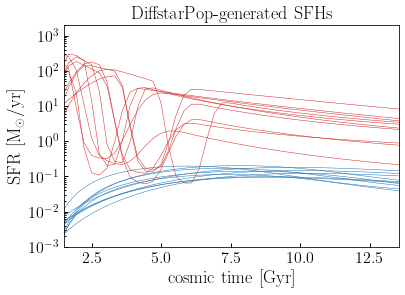

In [10]:
mskm115 = np.abs(galcat['logsm_t_obs'] - 9.0) < 0.2
mskm135 = np.abs(galcat['logsm_t_obs'] - 11.5) < 0.2

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(1.5, galcat['t_obs'])
ylim = ax.set_ylim(1e-3, 2e3)
yscale = ax.set_yscale('log')

mred = u'#d62728' 
morange = u'#ff7f0e'  
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 
mpurple = u'#9467bd' 
for i in range(10):
    __=ax.plot(galcat['t_table'], galcat['sfh_table'][mskm115][i], lw=0.5, color=mblue)
    __=ax.plot(galcat['t_table'], galcat['sfh_table'][mskm135][i], lw=0.5, color=mred)

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR}\ {\rm [M_{\odot}/yr]}$')
title = ax.set_title(r'${\rm DiffstarPop}$-${\rm generated\ SFHs}$')

### Plot stellar-to-halo mass relation at $z_{\rm obs}$

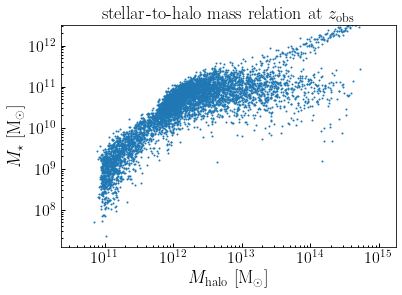

In [12]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
ylim = ax.set_ylim(10**7.1, 10**12.5)
__=ax.scatter(10**galcat['logmp_t_obs'], 10**galcat['logsm_t_obs_merging'], s=1)
xlabel = ax.set_xlabel(r'$M_{\rm halo}\ {\rm [M_{\odot}]}$')
ylabel = ax.set_ylabel(r'$M_{\star}\ {\rm [M_{\odot}]}$')
title = ax.set_title(r'${\rm stellar}$-${\rm to}$-${\rm halo\ mass\ relation\ at\ }z_{\rm obs}$')

### Plot $F_{\rm sat}(M_{\star})$

Calculate the satellite fraction as a function of stellar mass. Nearly all galaxies are satellites since merging has not been implemented yet in this repo.

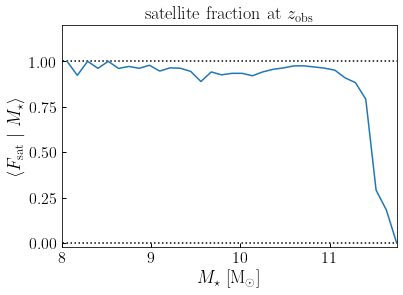

In [14]:
from scipy.stats import binned_statistic

logmp_bins = np.linspace(11.25, 14.25, 40)
logsm_bins = np.linspace(8, 12.5, 40)

mean_fsat_vs_logsm, __, __ = binned_statistic(galcat['logsm_t_obs_merging'], galcat['upid']!=-1, bins=logsm_bins)
logsm_binmids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(-0.02, 1.2)
xlim = ax.set_xlim(8, 11.75)
__=ax.plot(np.linspace(0, 20, 100), np.zeros(100), ':', color='k')
__=ax.plot(np.linspace(0, 20, 100), np.ones(100), ':', color='k')

__=ax.plot(logsm_binmids, mean_fsat_vs_logsm)

xlabel = ax.set_xlabel(r'$\log_{10}M_{\star}\ {\rm [M_{\odot}]}$')
ylabel = ax.set_ylabel(r'$\langle F_{\rm sat}\ \vert\ M_{\star}\rangle$')
title = ax.set_title(r'${\rm satellite\ fraction\ at\ }z_{\rm obs}$')

## Plot distributions of specific SFR

In [ ]:
fig, ax = plt.subplots(1, 1)

msk_cens = galcat['upid']==-1
lgssfr_bins = np.linspace(-14, -9, 50)

msk_logsm = np.abs(galcat['logsm_t_obs']-11) < 0.2
__=ax.hist(galcat['logssfr_t_obs'][msk_logsm], bins=lgssfr_bins, density=True, alpha=0.7, color=mred,
          label=r'$M_{\star}=10^{11}M_{\odot}$')

msk_logsm = np.abs(galcat['logsm_t_obs']-10) < 0.2
__=ax.hist(galcat['logssfr_t_obs'][msk_logsm], bins=lgssfr_bins, density=True, alpha=0.7, color=mgreen,
          label=r'$M_{\star}=10^{10}M_{\odot}$')

msk_logsm = np.abs(galcat['logsm_t_obs']-9) < 0.2
__=ax.hist(galcat['logssfr_t_obs'][msk_logsm], bins=lgssfr_bins, density=True, alpha=0.7, color=mpurple,
          label=r'$M_{\star}=10^{9}M_{\odot}$')

leg = ax.legend()
xlabel = ax.set_xlabel(r'$\log_{10}{\rm sSFR\ [yr^{-1}}]$')